In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm

In [2]:
imgspath = r"/home/isis0517/temp_data/database"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


80000


(500, 2000)


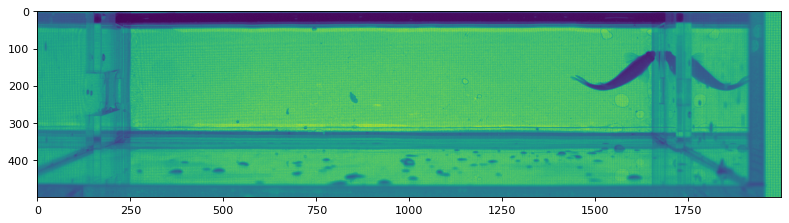

In [3]:
test_frame = np.load(os.path.join(imgspath, flist[8401+data_len]))
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(test_frame)
print(test_frame.shape)

In [4]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
# for s in tqdm(range(data_len)):
    
#     b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
#     b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     a = cv2.resize(a, (1200,400))
#     video.write(np.concatenate((b, a), axis=0))
# video.release()
# plt.imshow(a)


In [5]:
# tnum = np.random.randint(data_len,size = int(data_len*0.2))
# a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
# back = np.zeros(a.shape)
# for s in tnum:
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     back += a
# back = back/len(tnum)
# back = back.astype('uint8')

In [6]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
# kernel = np.ones((3,3), np.uint8)
# for s in tqdm(range(data_len)):
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
#     diff = cv2.erode(diff, kernel, iterations = 4)
#     diff = cv2.dilate(diff, kernel, iterations = 6)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
# video.release()

    
# diff = cv2.dilate(diff, kernel, iterations = 3)
# plt.imshow(diff)
# #cv2.imwrite("test.png", diff)

In [7]:
# labels = label(diff, connectivity=2, background=0)
# group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [8]:
tnum = np.random.randint(data_len,size = data_len//10)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


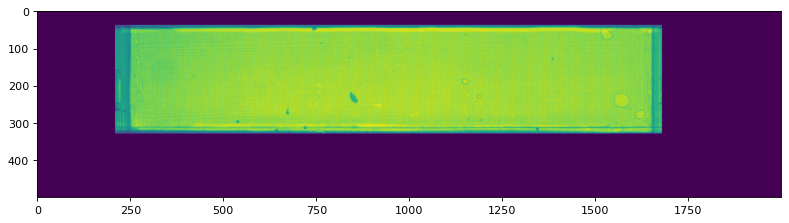

In [9]:
mask = np.full(background.shape, False)
mask[40:330,210:1680]=True
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(background*mask)

## 轉正圖片 & 儲存

In [10]:
abs_lim = 60

In [11]:
# imgs = []
# h_ans = []

# for s in tqdm(range(data_len)):
    
#     img = np.load(os.path.join(imgspath, flist[s+data_len]))
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         continue
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
    
#     imgs.append(rotated)
#     h_ans.append(angle)

### multi ver

In [12]:
# %%time
# from multiprocessing import Pool
# from numba import jit, njit

# def multi_cle_img(filename, background, mask, abs_lim):
#     img = np.load(filename)
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     return img

# map_arr = []

# with Pool() as pool:
#     map_arr = []
#     for s in range(data_len):
#         path = os.path.join(imgspath, flist[s+data_len])
#         map_arr.append((path, background, mask, abs_lim))
#     print("pool start")
#     result = pool.starmap(multi_cle_img, map_arr)
# temp_imgs = result



In [13]:

# def multi_ans(img):
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         return 0
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     return angle

# with Pool() as pool:
#     print("pool start")
#     result = pool.map(multi_ans, temp_imgs)
# h_ans = result
# print("end")
# imgs = []
# #h_ans = []

# def multi_rot_img(img, angle):
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
#     return img

# with Pool() as pool:
#     map_arr = []
#     for s in range(len(h_ans)):
#         map_arr.append((temp_imgs[s], h_ans[s]))
#     print("pool start")
#     result = pool.starmap(multi_rot_img, map_arr)


In [51]:
%%time
from multiprocessing import Pool
from numba import jit, njit

abs_lim = 60
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 120
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        return 0
        
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((size, size), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle, pos


with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s+data_len])
        map_arr.append((path, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)

imgs = []
h_ans = []
poses = []

for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])
    poses.append(temp[2])

pool start
CPU times: user 2.59 s, sys: 3.32 s, total: 5.91 s
Wall time: 3min 5s


-2.2655346029916


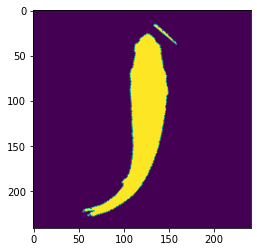

In [15]:
s = 8401  
sk = NT_skeleton(imgs[s])

print(h_ans[s])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(imgs[s])
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [16]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs)):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

  0%|          | 0/40000 [00:00<?, ?it/s]

## apply the eigenfish

In [17]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, er_num=2, di_num=3)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print("sk error")
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        break
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
            break
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    han_sks.append(han_sk)
print(len(han_sks))    


## 20000張 1:25

  0%|          | 0/40000 [00:00<?, ?it/s]

40000


In [18]:
%%script false --no-raise-error
def NT_skeleton_t(img, **kwargs):
    """

    :param img: the img of the zebrafish, it must be uint8 with 1 channel img
    :kwargs
        er_num: the number of iteration for erode.
        di_num: the number of iteration for dilate.
        sk_num: the number of node in skeleton.
    :return sk: The skeleton of fish
    """

    sk_num = kwargs.setdefault('sk_num', 10)
    ekernel = np.array([[0, 1, 0],
                        [1, 0, 1],
                        [0, 1, 0]], dtype='uint8')
    assert img.dtype == 'uint8' or img.dtype == np.uint8, "it is not uint8"

    img = pre_img(img, **kwargs)
    labels = label(img, connectivity=1, background=0)
    group = regionprops(labels, cache=True)

    n, index = 0, 0
    area = 0
    for com in group:
        if com.area > area:
            index = n
            area = com.area
    com = group[index]

    # the minimums box contain all points of the img
    min_row, min_col, max_row, max_col = com.bbox
    # sub = img[min_row:max_row, min_col:max_col]

    min_row = min_row - 2
    min_col = min_col - 2
    max_row = max_row + 2
    max_col = max_col + 2

    # sub = np.pad(sub,((2,2),(2,2)),'constant',constant_values = (0,0))

    # the minimums box's size
    row, col = (max_row - min_row, max_col - min_col)
    points = com.coords - np.array([min_row, min_col])

    sub = np.zeros((row, col), dtype=np.uint8)
    sub[points[:, 0], points[:, 1]] = 255
    # cut to smallest size
    erosion = cv2.erode(sub, ekernel, iterations=1)
    height = cv2.distanceTransform(erosion, cv2.DIST_L2, 3)[points[:, 0], points[:, 1]]

    not_known = erosion > 100
    is_bound = np.logical_xor(erosion, sub)

    # points

    points_ord = np.argsort(height)

    U, count = find_U(is_bound, points[points_ord], not_known)  # 0.3ms

    result = find_cen(U, count)  # 1ms
    result = result * (erosion > 100)
    
    labels = label(result, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        print(com.area)
        if com.area > area:
            index = com.label
            area = com.area
    result = labels==index
    
    point = np.nonzero(result)
    point = list(zip(point[0], point[1]))

    skeleton = find_ske(result, point, sub, sim_num=sk_num) + np.array([min_row, min_col])

    return skeleton


In [19]:
%%script false --no-raise-error
s = 1018   
img = pre_img(imgs[s])
sk = NT_skeleton_t(imgs[s], er_num=2, di_num=3)
print(sk)
draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

## find the pca

[0.7914497  0.15956198 0.03512149] 0.9861331766224385


array([ 0.02400158, -0.03482249, -0.02986163])

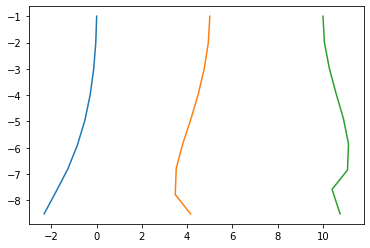

In [20]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

## apply the Kmeans

In [21]:
from sklearn.cluster import KMeans

n_clusters = 25
pos_kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=40)
pos_kmeans.fit(pca_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

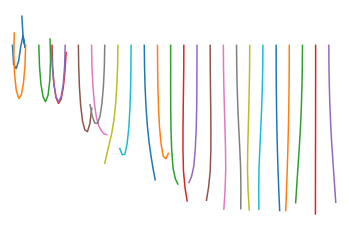

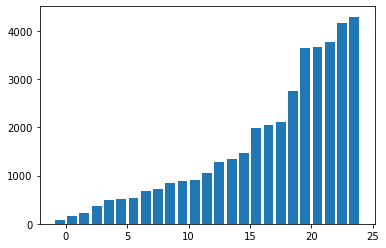

222


In [22]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()
print(nums[ords[2]])

0


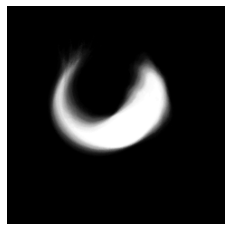

1


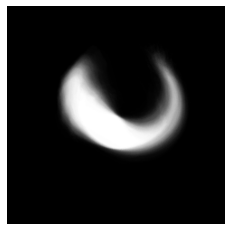

2


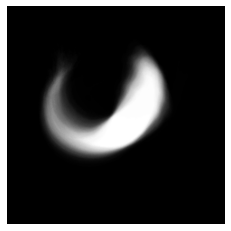

3


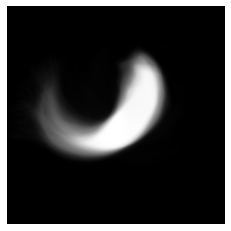

4


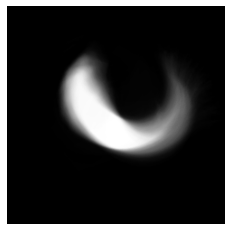

5


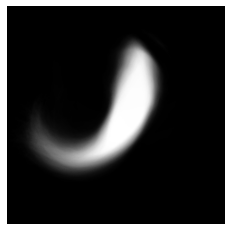

6


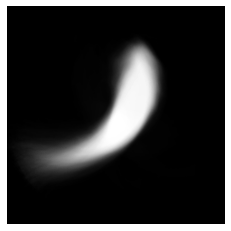

7


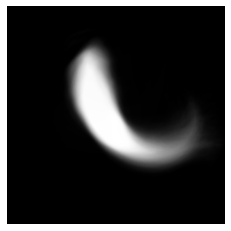

8


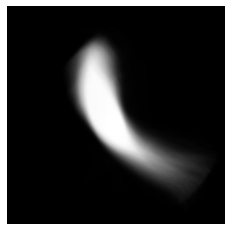

9


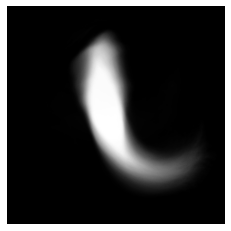

10


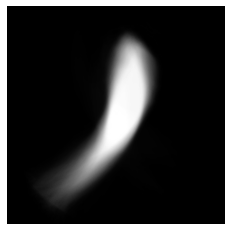

11


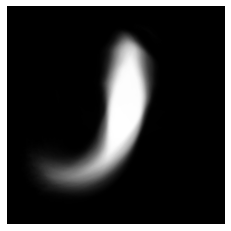

12


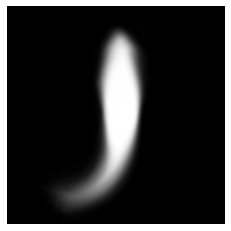

13


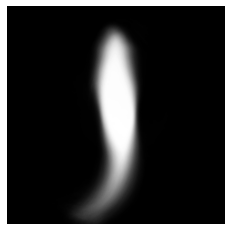

14


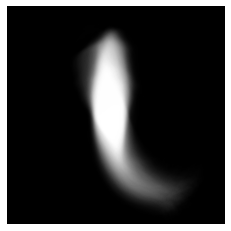

15


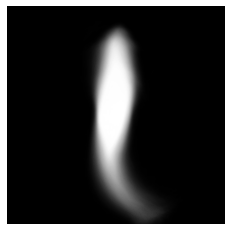

16


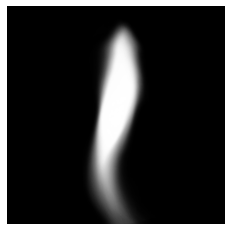

17


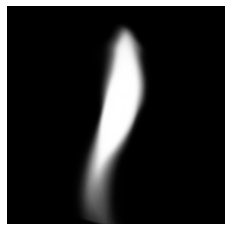

18


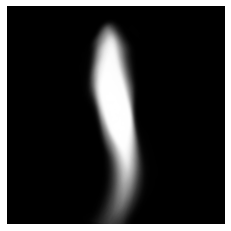

19


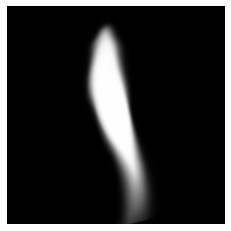

20


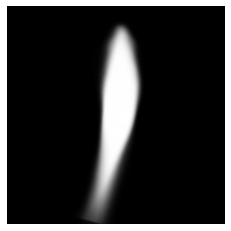

21


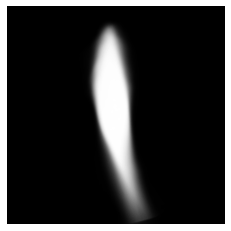

22


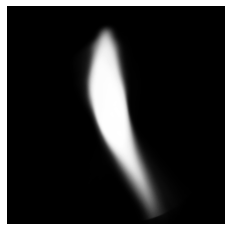

23


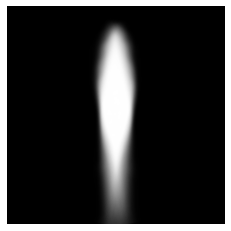

24


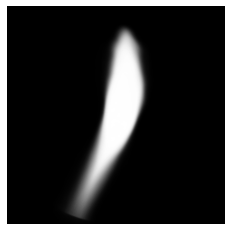

In [23]:
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()

In [24]:
_, bins = np.histogram(np.abs(h_ans))
dic_ans = np.digitize(np.abs(h_ans), bins)

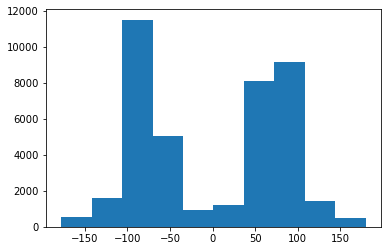

In [25]:
_ = plt.hist(np.array(h_ans)/np.pi*180)

# 用 pca + angle 做kmeans

In [26]:
%%time
from sklearn.cluster import KMeans


merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
n_clusters = 180
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr)
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_


CPU times: user 3min 10s, sys: 1.37 s, total: 3min 11s
Wall time: 24.4 s


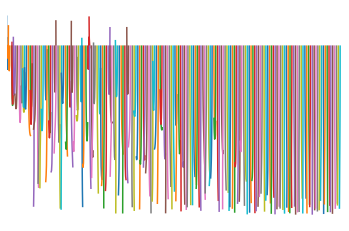

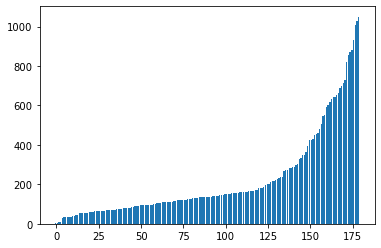

Text(0.5, 0, 'angle')

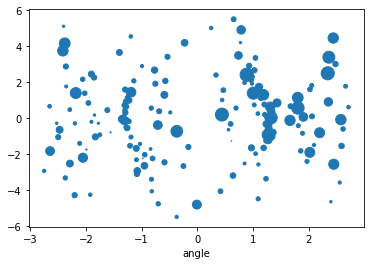

In [27]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

# 產生對應的side view

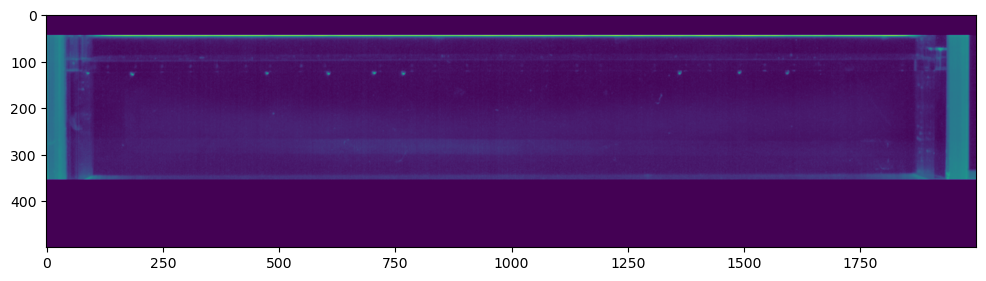

In [28]:
tnum = np.random.randint(data_len,size = int(data_len*0.1))
a = np.load(os.path.join(imgspath, flist[10]))
side_back = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    a = cv2.blur(a, ksize=(3, 3))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)

aq_mask = np.full(a.shape, False)
aq_mask[45:355, ...] = True
plt.imshow(side_back*aq_mask)
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')


-0.6


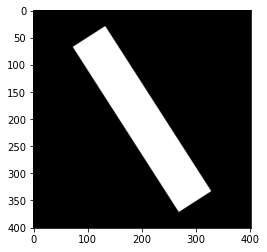

In [29]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (20, 165), (380, 235), (255,255,255), -1)
M = cv2.getRotationMatrix2D((200, 200), (1)/(np.pi)*180, 1)
rotated = cv2.warpAffine(stand, M, (401,401))
stands = []
rot_an = []
level_lim = 50
for s in range(level_lim):
    an = (-1+(2*s/level_lim))
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    stands.append(cv2.warpAffine(stand, M, (401,401)))
    rot_an.append(an)
plt.imshow(stands[10])
print(rot_an[10])

M = cv2.getRotationMatrix2D((200, 200), -rot_an[0]/(np.pi)*180, 1)
plt.imshow(cv2.warpAffine(stands[0], M, (401,401)))
plt.imshow(stands[0])

In [30]:
# sideviews = []
# kernel = np.ones((3,3), np.uint8)
    
# for s in tqdm(range(data_len)):
#     raw = np.load(os.path.join(imgspath, flist[s]))
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
#     diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
#     diff = cv2.erode(diff, kernel, iterations = 7)
#     diff = cv2.dilate(diff, kernel, iterations = 10)
    
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
#     side = cv2.bitwise_and(a, a, mask = diff)#apply mask
#     img = cutting_img(side, get_pos(diff), size = 200)
    
#     bacis = []
#     for num, stand in enumerate(stands):
#         bacis.append(np.sum(np.logical_and(img ,stand)))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))

#     sideviews.append(img)
    

# #cv2.imwrite("test.png", diff)

## multi ver

In [31]:
%%time
from multiprocessing import Pool
from numba import jit, njit

@jit(nogil=True)
def muti_img(filepath, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an):
    
    raw = np.load(filepath)
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    diff = cv2.erode(diff, kernel, iterations = 1)
    diff = cv2.dilate(diff, kernel, iterations = 7)
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, get_pos(diff), size = 200)
    
    bacis = [0]*len(stands)
    for num, stand in enumerate(stands):
        bacis[num] = np.sum(np.logical_and(img ,stand))
    bigarg = np.argmax(bacis)
    an = -rot_an[bigarg]
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    if bacis[bigarg] > 20000:
        img = cv2.warpAffine(img, M, (401,401))
    
#     bacis = [0]*len(stands)
#     for num, stand in enumerate(stands):
#         bacis[num] = np.sum(np.logical_and(img ,stand))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))
    
    return img

with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s])
        map_arr.append(path)
    print("pool start")
    result = pool.map(muti_img, map_arr, chunksize=20)
sideviews = result

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>



pool start


<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object m

<timed exec>:4: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
/home/isis0517/anaconda3/envs/zebra/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True.

File "<timed exec>", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/isis0517/anaconda3/envs/zebra/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<timed exec>", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,
<timed exec>:4: NumbaWarning: Code running in object mo

CPU times: user 1min 23s, sys: 39.6 s, total: 2min 3s
Wall time: 5min 15s


40000


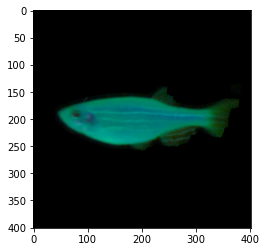

In [32]:

print(len(result))
img = result[5555]

plt.imshow(img)
plt.show()

np.savez("0421-sideviews.npz", sideviews)

In [33]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
#             print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper+1)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
            #print(upper, lower)
        return self.ords[lower]
                    
            

## set angle range 

In [34]:
an_mask = np.where(np.logical_and(np.abs(h_ans)>1.2, np.abs(h_ans)<2), 1, 0)
print(an_mask[15240])
merge_arr = np.concatenate((np.expand_dims(an_mask, axis=1), pca_sks), axis=1)
sorter = SortSearch(merge_arr)
print(sorter.ords[:10])
print(sorter.inv_ords[sorter.ords])

0
[ 4181 11410 21740 19017 34430 13036 22930  5763  3249 35868]
[    0     1     2 ... 39997 39998 39999]


<ipython-input-33-7d10fef3e848>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.inv_ords = np.zeros(self.length, dtype=np.int)
<ipython-input-33-7d10fef3e848>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

In [35]:
print(sorter.sort_arr[:10])

[[ 0.         -5.93448508 -0.54662073  0.26592922]
 [ 0.         -5.90355255 -0.69358102  0.58071784]
 [ 0.         -5.89295358 -0.47626921  0.43141686]
 [ 0.         -5.87822728 -0.5079773   0.4978321 ]
 [ 0.         -5.86657071 -0.32347881  0.17614909]
 [ 0.         -5.86483251 -0.38373076  0.30036334]
 [ 0.         -5.84939389 -0.57803883  0.55854423]
 [ 0.         -5.84506632 -0.29199276  0.16511467]
 [ 0.         -5.77444363 -0.69171334  0.53667594]
 [ 0.         -5.76005778 -0.5208756   0.55884549]]


# 用 sideview 對應出各個 kmeans center

In [36]:
#%%time
merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)

cen_inds = []

cen_set =  {s:[] for s in range(n_clusters)}
    
for s, label in enumerate(labels):
    cen = centers[label]
    arr = merge_arr[s]
    dis = np.linalg.norm(arr-cen)
    cen_set[label].append((s, dis))
    
for s in range(n_clusters):
    cen_set[s].sort(key=lambda x: x[1])
    
cen_inds = [cen_set[s][0][0] for s in range(n_clusters)]
print(cen_inds[:10])
#ind = 177

class ImgGetor:
    def __init__(self, cen_set, B=1):
        
        for s in range(len(cen_set)):
            cen_set[s].sort(key=lambda x: x[1])
        self.cen_set = cen_set.copy()
        self.cen_probs = []
        self.cen_Qs = []
        for sett in self.cen_set.values():
            Q = 0
            #print(sett)
            length = 10 if len(sett) > 10 else len(sett)
            probs = []
            for s in range(length):
                P = np.exp(-B*(sett[s][1]))
                Q += P
                probs.append((sett[s][0], P))
            self.cen_probs.append(probs)
            self.cen_Qs.append(Q)
    
    def label2img(self, label, rat=1):
        if rat>=1 or rat<0:
            #print("error")
            rat = rat=np.random.rand()
        #print(rat)
        rat = rat*self.cen_Qs[label]
        CP = 0
        for s in self.cen_probs[label]:
            CP += s[1]
            ind = s[0]
            
            if CP > rat:
                break
        #print(self.cen_probs[label])
        return ind
        
geter = ImgGetor(cen_set, B=120)
print(geter.label2img(1))

[2861, 16685, 38752, 19047, 14837, 844, 35787, 5403, 3369, 24195]
16685


In [37]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for label in tqdm(labels[20000:30000]):
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

  0%|          | 0/10000 [00:00<?, ?it/s]

# load the other vidoe

this data is hard to get the posture 

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


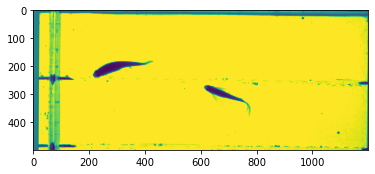

In [44]:
path2 = r"/media/isis0517/QVO2/0419/FaMb1/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a)

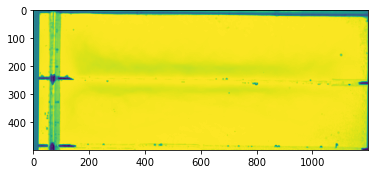

In [45]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.1))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    a = cv2.blur(a, ksize=(3, 3))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

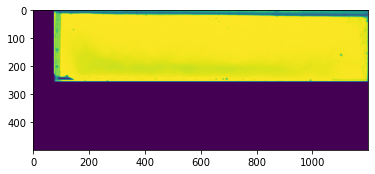

In [46]:
new_mask = np.full(new_background.shape, False)
new_mask[:255, 75:] = True
plt.imshow(new_background*new_mask)

In [ ]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)

new_imgs = []
new_h_ans = []
new_poses = []
new_han_sks = []
for filename in tqdm(flist2[:]):
    img = np.load(os.path.join(path2, filename))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>80, 255, 0).astype('uint8')
    pos = get_pos(img)
    new_poses.append(pos)
    img = cutting_img(img, pos, 150)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1, 0]) # this is the baseline vector
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    h_an = angle
    M = cv2.getRotationMatrix2D((150, 150), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (301,301))
    
    try:
        sk = NT_skeleton(rotated)
    except Exception as e:
        print(s, e)
        continue
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(filename, vec_sk)
            draw = img.copy()
            cv2.circle(draw, (sk[0, 1], sk[0, 0]), 2, (0), -1)
            for n in range(len(sk)-1):
                cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
            plt.imshow(draw)
            plt.show()
            continue
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)   
    new_h_ans.append(h_an)
    new_imgs.append(rotated)
    new_han_sks.append(han_sk)
    
    
plt.imshow(imgs[120])

In [ ]:
_ = plt.hist(np.array(new_h_ans)/np.pi*180)

In [ ]:
s = 11603
img = np.load(os.path.join(path2, flist2[s]))
img = cv2.absdiff(new_background, img)
img = np.where(img>60, 255, 0).astype('uint8')
pos = get_pos(img)
new_poses.append(pos)
img = cutting_img(img, pos, 150)
sk = NT_skeleton(img, er_num=5, di_num=4)

draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    
vec_sk = []
for i in range(len(sk)-1):
    vec_sk.append(sk[i+1]-sk[i])

heading = vec_sk[0]
han_sk=[]

heading = heading/np.linalg.norm(heading)
for vec in vec_sk[1:]:
    vec = vec/np.linalg.norm(vec)
    a = heading
    b = vec

    #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if angle != angle:
        print("算錯啦")
        print(filename, vec_sk)
        draw = imgs.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        continue
    err = a-np.dot(b, get_rot_M(angle))
    if np.linalg.norm(err) > 0.1:
        #print("turning", a, np.dot(b, get_rot_M(-angle)))
        angle=-angle
    han_sk.append(angle)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))


In [ ]:
from sklearn.decomposition import PCA
new_pca = PCA(n_components=3)
new_pca.fit(new_han_sks)
pc1 = new_pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in new_pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(new_pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = new_pca.transform(new_han_sks)

In [ ]:
s = 2981
img = np.load(os.path.join(path2, flist2[s]))
plt.imshow(img*new_mask)

## generate the origin(database, no interact) path

In [58]:
#%%time
back = np.zeros((side_back.shape[0]*5, side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_new.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 20, (back.shape[1], back.shape[0]))

for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
back[400:,:,:]=255
    
rand_ints = np.random.rand(100000)
for s, label in enumerate(tqdm(labels[0:10000])):
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    pos = (200,poses[s][1])
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
video.release()
np.save("video_poses", video_poses)
print(len(set(labels)))

  0%|          | 0/10000 [00:00<?, ?it/s]

180


## Adding the start singal with larger size

In [ ]:
#%%time
new_pca_sks = pca.transform(new_han_sks)
new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0]*5, side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_new.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30, (back.shape[1], back.shape[0]))

for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []

back[400:,:,:]=255
rand_ints = np.random.rand(len(new_labels))
for s, label in enumerate(tqdm(new_labels)):
    ind = geter.label2img(label, rat=rand_ints[s])
    img = sideviews[ind].copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("video_poses", video_poses)
print(len(set(new_labels)))

## red dot ver

In [ ]:
#%%time
#new_pca_sks = pca.transform(new_han_sks)
#new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
#new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0]*5, side_back.shape[1], 3), dtype='uint8')
#geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_red.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (back.shape[1], back.shape[0]))

for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
back[400:,:,:]=255
for s, label in enumerate(tqdm(new_h_ans)):
    
    img = back.copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = cv2.circle(img, (pos[1], pos[0]), 30, (10, 10, 180), -1)
    img = cv2.putText(img, f"{s}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full(back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("video_poses", video_poses)

In [ ]:
plt.imshow(np.load(os.path.join(imgspath, flist[8759])))
img = muti_img(os.path.join(imgspath, flist[8759]))
plt.imshow(img)
np.save("video_poses", video_poses)


# another vidoe

In [ ]:
path2 = r"/media/isis0517/QVO2/0115/03"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(temlist))
flist2 = temlist[:-100]
img = np.load(os.path.join(path2,flist2[0]))
#img = (img/255)**0.6*255
plt.imshow(img)

In [ ]:
gamma = 0.7
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(img, lookUpTable)
plt.imshow(res)

In [ ]:
new_background = np.zeros(img.shape, dtype=np.float)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.2))
for s in tqdm(tnum):
    img = np.load(os.path.join(path2, flist2[s]))
    img = cv2.LUT(img, lookUpTable)
    img = cv2.blur(img, (5, 5))
    new_background += img
    
new_background = new_background / len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

In [ ]:
new_imgs = []
for filename in tqdm(flist2):
    img = np.load(os.path.join(path2, filename))
    img = cv2.LUT(img, lookUpTable)
    img = img.astype(np.uint8)
    img = cv2.blur(img, (5, 5))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>30, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    new_imgs.append(img)
plt.imshow(img)

In [ ]:
now_roteds = []
new_h_ans = []

for img in tqdm(new_imgs):
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    now_roteds.append(rotated)
    new_h_ans.append(angle)

In [ ]:

new_han_sks=[]

for s, img in enumerate(tqdm(now_roteds)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    new_han_sks.append(han_sk)
print(len(new_han_sks))    


In [ ]:
new_pca_sks = pca.transform(new_han_sks)
new_merge_sks = np.concatenate((np.ones((len(new_pca_sks),1)), new_pca_sks), axis=1)
sorter.search(new_merge_sks[0])

In [ ]:
video = cv2.VideoWriter("output_v.avi", 0, 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for sks in tqdm(new_merge_sks[:3000]):
    ind = sorter.search(sks)
    if ind == 18483:
        print(sks, merge_arr[18483])
        break
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

# t-sne

In [ ]:

%%time
loadding = np.load("0419-sideviews.npz")

sideviews = loadding["arr_0"]

from sklearn import manifold

X = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).flatten() for x in sideviews]
Tsne = manifold.TSNE(n_components=2, init='random', verbose=2)
t_lables = Tsne.fit_transform(X)

In [ ]:
#plt.scatter(*t_lables.T, s=0.1)

arr = []

for s, label in enumerate(t_lables):
    if label[0]<72 and label[0]>71 and label[1]<-37 and label[1]>-38:
        arr.append(s)
        print(s)
        plt.imshow(sideviews[s])
        plt.show()
print(t_lables[8759])